# Seasonality of MHW

### Summary

This notebook uses the `.pickle` output of the `.detect()` function of the `marineHeatWaves` package to look at the seasonal distribution of MHWs.

### Outputs

- Figure 12

### Notes
- median and standard error https://influentialpoints.com/Training/standard_error_of_median.htm
- matplotlib docs `bootstrap` parameter describe bootstrapping process
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

In [1]:
import os
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import xarray as xr
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw')
SAVE_FIGS = False

In [3]:
path = os.path.join(REPO_ROOT, 'data/02_interim', 'mhw_eventstats_dict.pickle')
with open(path, 'rb') as handle:
    event_statistics = pickle.load(handle)

## Pre-processing

In [4]:
# Count of mhw grouped by month
months = []
full_df = pd.DataFrame()
for i in range(event_statistics.shape[0]):
    for j in range(event_statistics.shape[1]):
        df = pd.DataFrame(event_statistics[i, j])
        df.date_start = pd.to_datetime(df.date_start)
        if not df.empty:
            df['month'] = df.date_start.dt.month
            full_df = pd.concat([full_df, df])

In [6]:
monthly_counts = full_df.groupby([full_df.month, full_df.date_start.dt.year])['date_start'].count()

In [7]:
years = list(range(1, 13)) * 21
new_multiindex = []
for month in range (1, 13):
    for year in range(2002, 2023):
        new_multiindex.append((month, year))

In [8]:
new_index = pd.MultiIndex.from_tuples(new_multiindex, names = ['month', 'year'])
monthly_counts = monthly_counts.reindex(new_index, fill_value=0)

In [9]:
occurences_avg = monthly_counts.groupby('month').mean()
occurences_std = monthly_counts.groupby('month').std()
occurences_st_err_mean = occurences_std.div(np.sqrt(monthly_counts.groupby('month').sum()), 
                                            axis='index')

In [16]:
df = full_df[['month', 'duration', 'intensity_max', 'intensity_cumulative', 'rate_onset', 'rate_decline']]

In [17]:
output_dict = {}
for characteristic in ['duration', 'intensity_max', 'intensity_cumulative',
       'rate_onset', 'rate_decline']:
    for name, group in df[['month', characteristic]].groupby('month'):
        if name == 1:
            jan = group[characteristic].values
        elif name == 2:
            feb = group[characteristic].values
        elif name == 3:
            mar = group[characteristic].values
        elif name == 4:
            apr = group[characteristic].values
        elif name == 5:
            may = group[characteristic].values
        elif name == 6:
            jun = group[characteristic].values
        elif name == 7:
            jul = group[characteristic].values
        elif name == 8:
            aug = group[characteristic].values
        elif name == 9:
            sep = group[characteristic].values
        elif name == 10:
            oct = group[characteristic].values
        elif name == 11:
            nov = group[characteristic].values
        elif name == 12:
            dec = group[characteristic].values
    
    output_dict[characteristic] = [jan, feb, mar, apr, may, jun, jul, aug, 
                                   sep, oct, nov, dec]

## Plot

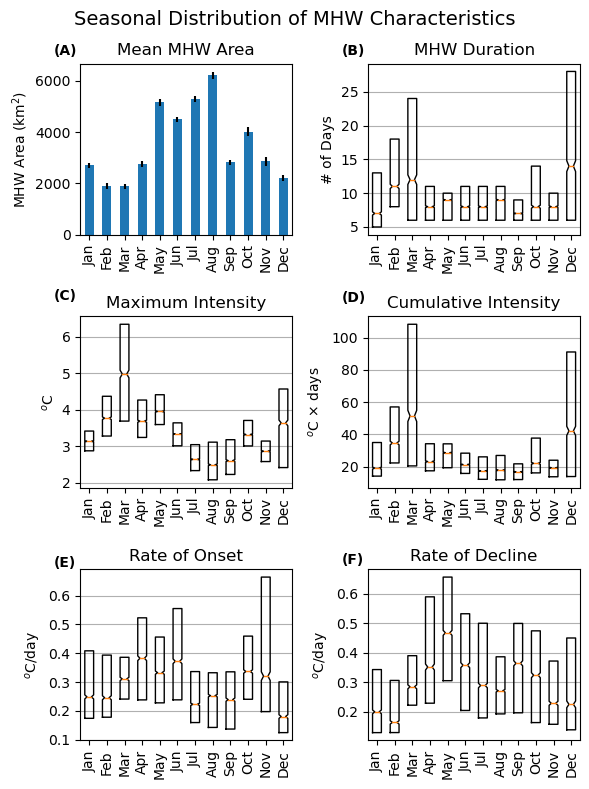

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(6, 8))
fig.suptitle('Seasonal Distribution of MHW Characteristics', fontsize=14)

# only boostrap when saving the figure, because it takes several minutes
if SAVE_FIGS is True:
    bootstrap=2000
else:
    bootstrap=None

(occurences_avg*25).plot(ax=axes[0, 0], kind='bar', title='Mean MHW Area')
axes[0, 0].errorbar(range(0, 12), (occurences_avg*25).values, yerr=(occurences_st_err_mean*25).values,
                   fmt='none', ecolor='black')
axes[0, 0].set_ylabel('MHW Area (km$^2$)')
axes[0, 0].text(-2, 7000, '(A)', weight='bold')

axes[0, 1].boxplot(output_dict['duration'], whis=0, bootstrap=bootstrap, showfliers=False, 
                   showcaps=False, notch=True)
axes[0, 1].set_ylabel('# of Days')
axes[0, 1].set_title('MHW Duration')
axes[0, 1].text(-1, 30.5, '(B)', weight='bold')

axes[1, 0].boxplot(output_dict['intensity_max'], whis=0, bootstrap=bootstrap, showfliers=False, 
                   showcaps=False, notch=True)
axes[1, 0].set_ylabel('$^o$C')
axes[1, 0].set_title('Maximum Intensity')
axes[1, 0].text(-1, 7, '(C)', weight='bold')

axes[1, 1].boxplot(output_dict['intensity_cumulative'], whis=0, bootstrap=bootstrap, showfliers=False, 
                   showcaps=False, notch=True)
axes[1, 1].set_ylabel(r'$^o$C $\times$ days')
axes[1, 1].set_title('Cumulative Intensity')
axes[1, 1].text(-1, 122, '(D)', weight='bold')

axes[2, 0].boxplot(output_dict['rate_onset'], whis=0, bootstrap=bootstrap, showfliers=False, 
                   showcaps=False, notch=True)
axes[2, 0].set_ylabel('$^o$C/day')
axes[2, 0].set_title('Rate of Onset')
axes[2, 0].text(-1, 0.7, '(E)', weight='bold')

axes[2, 1].boxplot(output_dict['rate_decline'], whis=0, bootstrap=bootstrap, showfliers=False, 
                   showcaps=False, notch=True)
axes[2, 1].set_ylabel('$^o$C/day')
axes[2, 1].set_title('Rate of Decline')
axes[2, 1].text(-1, 0.7, '(F)', weight='bold')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
          'Oct', 'Nov', 'Dec']

for ax in axes.flatten():
    ax.set_xlabel('Month')
    # label months by name instead of number
    ax.set_xticklabels(months, rotation=90)
    # use only y axis gridlines
    ax.grid(axis='y')
    ax.set_xlabel('')

axes[0, 0].grid(False)

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/03_marineheatwaves' / 'seasonality.png',
                dpi=450, bbox_inches='tight')

## Extra plots

### Is the distribution of observations normal?

Visualizing the distribution shape to determine the most appropriate statsitics for analysis.

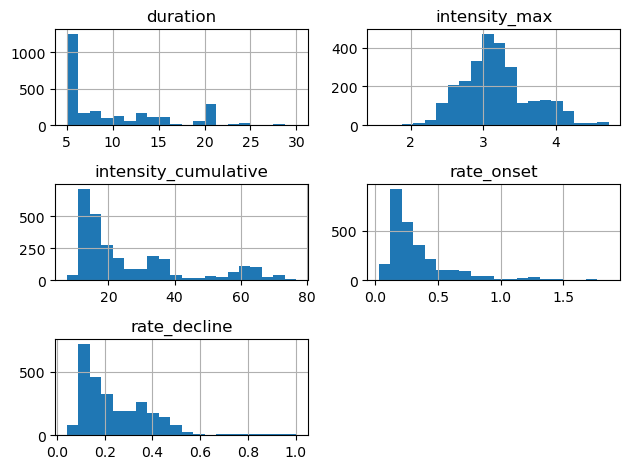

In [19]:
full_df.query('month == 1')[['duration', 'intensity_max', 'intensity_cumulative', 'rate_onset', 'rate_decline']].hist(bins=20)
plt.tight_layout()

### In which season do most MHW occur?

In [21]:
def get_season(row):
    season = None
    if row.date_start.month in [6, 7, 8]:
        # season = 'JJA'
        season = 2
    elif row.date_start.month in [9, 10, 11]:
        # season = 'SON'
        season = 3
    elif row.date_start.month in [12, 1, 2]:
        # season = 'DJF'
        season = 4
    elif row.date_start.month in [3, 4, 5]:
        # season = 'MAM'
        season = 1
    else:
        season = np.nan
    return season

In [22]:
seasons = np.full(event_statistics.shape, np.nan)
# seasons = [[0]*event_statistics.shape[1]]*event_statistics.shape[0]
for i in range(event_statistics.shape[0]):
    for j in range(event_statistics.shape[1]):
        df = pd.DataFrame(event_statistics[i, j])
        df.date_start = pd.to_datetime(df.date_start)
        if not df.empty:
        # df['month'] = df.date_start.dt.month
            df['season'] = df.apply(get_season, axis=1)
            seasons[i, j] = df.season.mode().iloc[0]  # TODO just picking one
        else:
            seasons[i, j] = np.nan

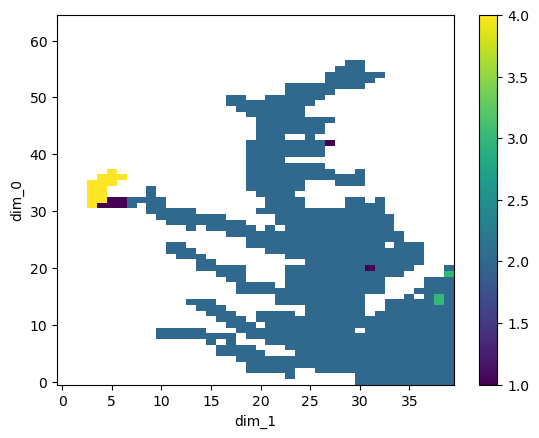

In [23]:
xr.DataArray(seasons).plot()